In [104]:

from osgeo import gdal

import numpy
import torch
import torch.utils.data
import torch.optim
import torchvision as vision
import torchvision.transforms.v2 as v2
import tqdm
import matplotlib.pyplot as pyplot
from typing import Callable, Tuple, List, Any, Union
from pathlib import Path

import models

has_cuda = torch.cuda.is_available()
if has_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 1. Classifier Model (2-layer CNN)

## Load Dataset

In [ ]:
BATCH_SIZE = 2000
TRAIN_SET_SIZE = 0.8

def target_transform(label: int) -> torch.Tensor:
    """Transform label into one-hot encoded."""
    l = torch.zeros(10)
    l[label] = 1
    return l


dataset = vision.datasets.ImageFolder(
    root="dataset",
    transform=vision.transforms.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    target_transform=target_transform)

train_set, test_set = torch.utils.data.random_split(dataset, [TRAIN_SET_SIZE, 1 - TRAIN_SET_SIZE])
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"The dataset has {len(dataset)} samples.")
print(f"The train set has {len(train_set)} samples.")
print(f"The test set has {len(test_set)} samples.")

## Define Training Hyperparameters

In [ ]:
cls = models.Conv2Layers(n_classes=10, image_size=(64, 64))

if has_cuda:
    cls = cls.cuda()

criterion = torch.nn.BCELoss(reduction="mean")
optimizer = torch.optim.Adam(cls.parameters(), lr=1e-3)
    
loss_hist = []

# Train

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0.0
    for inputs, labels in tqdm.tqdm(train_loader):
        if has_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
        y = cls(inputs)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)

pyplot.plot(loss_hist)

## Evaluation

In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0

for inputs, labels in tqdm.tqdm(test_loader):
    if has_cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
    y = cls(inputs)
    acc = torch.argmax(y, dim=1) == torch.argmax(labels, dim=1)
    y = torch.argmax(y, dim=1).to(bool)
    labels = torch.argmax(labels, dim=1).to(bool)
    tp += ((y == True) & (labels == True)).sum()
    tn += ((y == False) & (labels == False)).sum()
    fp += ((y == True) & (labels == False)).sum()
    fn += ((y == False) & (labels == True)).sum()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

## Save Model

In [ ]:
torch.save(
    {
        "model_state_dict": cls.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "outputs/cls_state.pt")

# 2. Segmentation Model (U-Net)

## Load Dataset

In [2]:
BATCH_SIZE = 2000
TRAIN_SET_SIZE = 0.8

def target_transform_2(label: int) -> torch.Tensor:
    """Transform label into segmentation matrix."""
    l = torch.zeros((10, 64, 64))
    l[label] = torch.ones((64, 64))
    return l


dataset = vision.datasets.ImageFolder(
    root="dataset",
    transform=vision.transforms.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    target_transform=target_transform_2)

train_set, test_set = torch.utils.data.random_split(dataset, [TRAIN_SET_SIZE, 1 - TRAIN_SET_SIZE])
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"The dataset has {len(dataset)} samples.")
print(f"The train set has {len(train_set)} samples.")
print(f"The test set has {len(test_set)} samples.")

The dataset has 27000 samples.
The train set has 21601 samples.
The test set has 5399 samples.


## Define Training Hyperparameters

In [3]:
def gaussian_filter(kernel_size, sigma=1, mean=0):
    x, y = numpy.meshgrid(numpy.linspace(-1, 1, kernel_size), numpy.linspace(-1, 1, kernel_size))
    dst = numpy.sqrt(x**2 + y**2)
    gauss = numpy.exp(-((dst - mean)**2 / (2.0 * sigma**2)))
    return gauss

loss_filter = torch.Tensor(gaussian_filter(64))
if has_cuda:
    loss_filter = loss_filter.cuda()

In [4]:
HIDDEN_CHANNELS = [8, 12, 16, 20]

unet = models.UNet(input_channels=3, n_classes=10, hidden_channels=HIDDEN_CHANNELS)
if has_cuda:
    unet = unet.cuda()

criterion2 = torch.nn.BCELoss(reduction="none")
optimizer2 = torch.optim.Adam(unet.parameters(), lr=1e-3)

loss_hist = []

# Train

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0.0
    for inputs, labels in tqdm.tqdm(train_loader):
        if has_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
        y = unet(inputs)
        loss = criterion2(y, labels)
        loss = (loss * loss_filter).mean()
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)

pyplot.plot(loss_hist)

## Evaluation

In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0

for inputs, labels in tqdm.tqdm(test_loader):
    if has_cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
    y = unet(inputs)
    y = torch.argmax(y, dim=1).to(bool)
    labels = torch.argmax(labels, dim=1).to(bool)
    tp += ((y == True) & (labels == True)).sum()
    tn += ((y == False) & (labels == False)).sum()
    fp += ((y == True) & (labels == False)).sum()
    fn += ((y == False) & (labels == True)).sum()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

## Save Model

In [ ]:
torch.save(
    {
        "model_state_dict": unet.state_dict(),
        "optimizer_state_dict": optimizer2.state_dict(),
    },
    "outputs/unet_state.pt")

# 3. Segmentation Model (13 Bands)

## Load Dataset

In [83]:
def pt_loader(path: str):
    data = torch.load(path)
    return data


class PtDatasetFolder(vision.datasets.DatasetFolder):
    def __init__(self, root: Union[str, Path], transform: Callable = None, target_transform: Callable = None):
        super().__init__(
            root=root,
            loader=pt_loader,
            extensions=[".pt"],
            transform=transform,
            target_transform=target_transform,
            is_valid_file=None,
            allow_empty=False,
        )

In [127]:
BATCH_SIZE = 2000
TRAIN_SET_SIZE = 0.8

def transform(data):
    return data / 3500.0

dataset = PtDatasetFolder(
    root="dataset13_pt",
    transform=transform,
)

train_set, test_set = torch.utils.data.random_split(dataset, [TRAIN_SET_SIZE, 1 - TRAIN_SET_SIZE])
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"The dataset has {len(dataset)} samples.")
print(f"The train set has {len(train_set)} samples.")
print(f"The test set has {len(test_set)} samples.")

The dataset has 27000 samples.
The train set has 21601 samples.
The test set has 5399 samples.


## Define Training Hyperparameters

In [59]:
def gaussian_filter(kernel_size, sigma=1, mean=0):
    x, y = numpy.meshgrid(numpy.linspace(-1, 1, kernel_size), numpy.linspace(-1, 1, kernel_size))
    dst = numpy.sqrt(x**2 + y**2)
    gauss = numpy.exp(-((dst - mean)**2 / (2.0 * sigma**2)))
    return gauss

loss_filter = torch.Tensor(gaussian_filter(64))
if has_cuda:
    loss_filter = loss_filter.cuda()

In [119]:
unet = models.UNet(input_channels=13, n_classes=10, hidden_channels=[8, 12, 16, 20])
if has_cuda:
    unet = unet.cuda()

criterion3 = torch.nn.BCELoss(reduction="none")
optimizer3 = torch.optim.Adam(unet.parameters(), lr=1e-3)

loss_hist = []

# Train

100%|██████████| 11/11 [00:28<00:00,  2.61s/it]


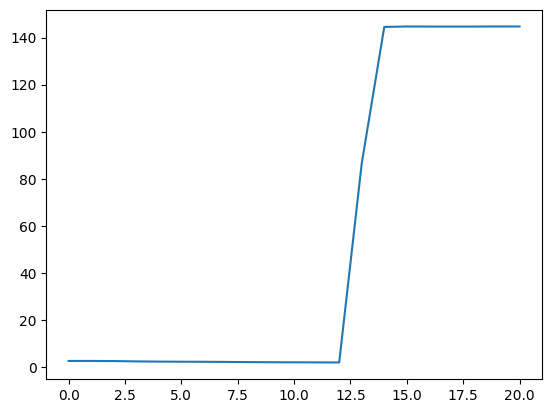

In [135]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0.0
    for inputs, labels in tqdm.tqdm(train_loader):
        labels_transformed = torch.zeros((labels.shape[0], 10, 64, 64), device=device)
        for idx in range(labels.shape[0]):
            labels_transformed[idx][labels[idx]] = torch.ones((64, 64), device=device)
        
        if has_cuda:
            inputs = inputs.float().cuda()
        
        y = unet(inputs)
        loss = criterion3(y, labels_transformed)
        loss = (loss * loss_filter).mean()
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)

pyplot.plot(loss_hist)

## Evaluation

In [145]:
tp = 0
tn = 0
fp = 0
fn = 0

for inputs, labels in tqdm.tqdm(test_loader):
    labels_transformed = torch.zeros((labels.shape[0], 10, 64, 64), device=device)
    for idx in range(labels.shape[0]):
        labels_transformed[idx][labels[idx]] = torch.ones((64, 64), device=device)
    
    if has_cuda:
        inputs = inputs.float().cuda()
    
    y = unet(inputs)
    y = torch.argmax(y, dim=1).to(bool)
    labels = torch.argmax(labels_transformed, dim=1).to(bool)
    tp += ((y == True) & (labels == True)).sum()
    tn += ((y == False) & (labels == False)).sum()
    fp += ((y == True) & (labels == False)).sum()
    fn += ((y == False) & (labels == True)).sum()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

Accuracy = 0.8873865604400635
Precision = 0.8873865604400635
Recall = 1.0


## Save Model

In [147]:
torch.save(
    {
        "model_state_dict": unet.state_dict(),
        "optimizer_state_dict": optimizer3.state_dict(),
    },
    "outputs/unet13_state.pt")